<a href="https://colab.research.google.com/github/joseop/ProyectoIA/blob/main/01_ProyectoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A continuacion instalamos y cargamos las opciones necesarias para cargar el dataset desde la plataforma de kaggle con nuestro usuario registrado en la competicion

In [11]:
!pip install -q kaggle 

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joseortizp","key":"6b3c9b6aa559814d7f47d457af4480fb"}'}

In [13]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
!cp kaggle.json ~/.kaggle/

In [15]:
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle competitions download -c home-credit-default-risk 

 99% 681M/688M [00:04<00:00, 178MB/s]
100% 688M/688M [00:04<00:00, 165MB/s]


In [17]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [18]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer


In [19]:
# Cargar los conjuntos de datos
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')

In [21]:
# Agrupe por la identificación del cliente (SK_ID_CURR), cuente la cantidad de préstamos anteriores 
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [22]:
application_train = application_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Rellena los valores que faltan con 0
application_train['previous_loan_counts'] = application_train['previous_loan_counts'].fillna(0)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# **Evaluación de la utilidad de la nueva variable con valor r**




Para determinar si la nueva variable es útil, podemos calcular el coeficiente de correlación de Pearsom (valor r) entre esta variable y el objetivo. Esto mide la fuerza de una relación lineal entre dos variables y varía de -1 (perfectamente lineal negativo) a +1 (perfectamente lineal positivo). El valor r no es la mejor medida de la "utilidad" de una nueva variable, pero puede dar una primera aproximación de si una variable será útil para un modelo de aprendizaje automático. Cuanto mayor sea el valor r de una variable con respecto al objetivo, es más probable que un cambio en esta variable afecte el valor del objetivo. Por lo tanto, buscamos las variables con el mayor valor absoluto r-valor en relación con el objetivo.

También podemos inspeccionar visualmente una relación con el objetivo mediante el gráfico de estimación de densidad del kernel (KDE).

# **Gráficos de estimación de densidad del kernel**

La gráfica de estimación de densidad kernel muestra la distribución de una sola variable (piense en ello como un histograma suavizado). Para ver las diferentes distribuciones que dependen del valor de una variable categórica, podemos colorear las distribuciones de manera diferente según la categoría. Por ejemplo, podemos mostrar la estimación de la densidad del kernel de los recuentos_de_préstamos_previos coloreados según si el objetivo = 1 o 0. El KDE resultante mostrará cualquier diferencia significativa en la distribución de la variable entre las personas que no pagaron su préstamo (OBJETIVO == 1 ) y las personas que lo hicieron (OBJETIVO == 0). Esto puede servir como indicador de si una variable será "relevante" para un modelo de aprendizaje automático.

Pondremos esta funcionalidad de trazado en una función para reutilizar para cualquier variable.

In [25]:
# Traza la distribución de una variable coloreada por el valor del objetivo
def kde_target(var_name, df):
    
    # Calcular el coeficiente de correlación entre la nueva variable y el objetivo
    corr = df['TARGET'].corr(df[var_name])
    
    # Calcule las medianas de reembolsado frente a no reembolsado
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Traza la distribución para target == 0 y target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # etiquetar la trama
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # imprimir la correlación
    print('La correlación entre %s y el OBJETIVO es %0.4f' % (var_name, corr))
    # Imprimir valores promedio
    print('Valor medio del préstamo que no se devolvió = %0.4f' % avg_not_repaid)
    print('Valor medio del préstamo que se devolvió =     %0.4f' % avg_repaid)

La correlación entre EXT_SOURCE_3 y el OBJETIVO es -0.1789
Valor medio del préstamo que no se devolvió = 0.3791
Valor medio del préstamo que se devolvió =     0.5460


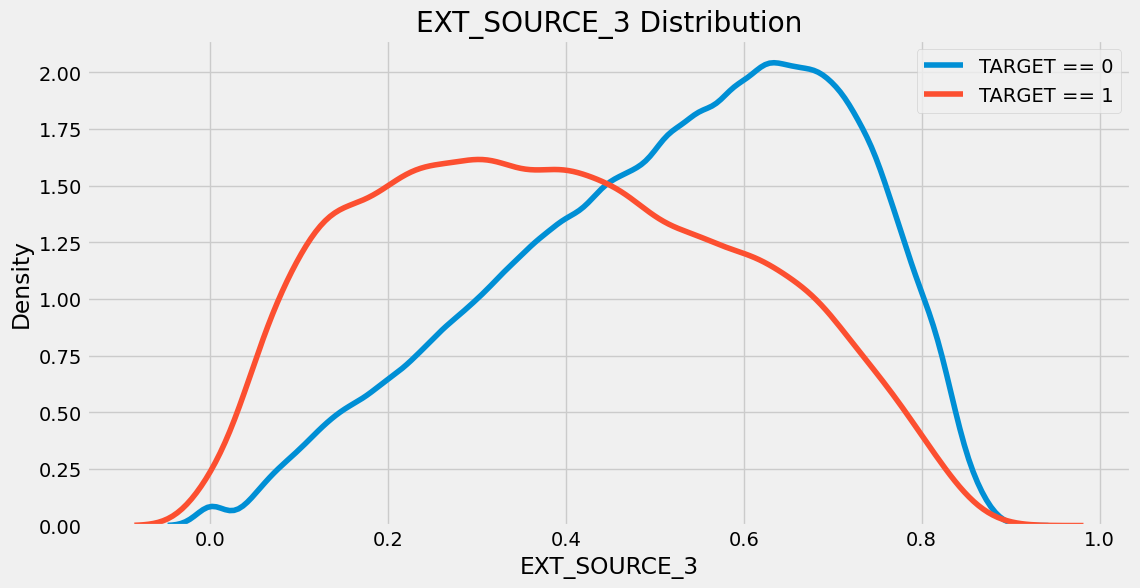

In [27]:
kde_target('EXT_SOURCE_3', application_train)